In [1]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD

import tensorflow.keras.backend as K

In [7]:
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
gpus = [x.name for x in local_device_protos if x.device_type == 'GPU']
len(gpus)

1

In [9]:
if len(gpus) > 0:
    print("Use Cuda LSTM and GRU")
    from tensorflow.keras.layers import CuDNNLSTM as LSTM
    from tensorflow.keras.layers import CuDNNGRU as GRU

Use Cuda LSTM and GRU


In [12]:
# config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 100  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [13]:
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1 

In [15]:
# load in the data
# download the data at: http://www.manythings.org/anki/
t = 0
for line in open('./data/translations/por.txt', encoding='utf8'):
    # only keep a limited number of samples
    t += 1
    if t > NUM_SAMPLES:
        break

    # input and target are separated by tab
    if '\t' not in line:
        continue

    # split up the input and translation
    input_text, translation = line.rstrip().split('\t')

    # make the target input and output
    # recall we'll be using teacher forcing
    target_text = translation + ' <eos>'
    target_text_input = '<sos> ' + translation

    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 16395


In [19]:
print(f'English Input:{input_texts[0]} - Target Portuguese:{target_texts[0]} -  Target Input Portuguese:{target_texts_inputs[0]}')

English Input:Go. - Target Portuguese:Vai. <eos> -  Target Input Portuguese:<sos> Vai.


In [21]:
#tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [24]:
input_sequences[5000]

[1, 574, 7, 164]

In [25]:
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 2084 unique input tokens.


In [26]:
# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)
max_len_input

5

In [28]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [29]:
target_sequences_inputs[5000]

[2, 1023, 100]

In [30]:
# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

Found 5479 unique output tokens.


In [31]:
# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

In [32]:
# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)

In [33]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

encoder_inputs.shape: (16395, 5)
encoder_inputs[0]: [ 0  0  0  0 22]


In [34]:
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_inputs[0]: [   2 1241    0    0    0    0    0    0    0]
decoder_inputs.shape: (16395, 9)


In [35]:
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
print("decoder_targets[0]:", decoder_targets[0])
print("decoder_targets.shape:", decoder_targets.shape)

decoder_targets[0]: [1241    1    0    0    0    0    0    0    0]
decoder_targets.shape: (16395, 9)


In [38]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('./data/word2vec/glove.6B.%sd.txt' % EMBEDDING_DIM), encoding='utf8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [39]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [40]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

In [41]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

In [42]:
# assign the values
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [43]:
##### build the model #####
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIM,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
encoder_outputs, h, c = encoder(x)
# encoder_outputs, h = encoder(x) #gru

# keep only the states to pass into decoder
encoder_states = [h, c]
# encoder_states = [state_h] # gru

# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)

# decoder_outputs, _ = decoder_gru(
#   decoder_inputs_x,
#   initial_state=encoder_states
# )

# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

# Compile the model and train it
model.compile(
  optimizer='rmsprop',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

Instructions for updating:
Colocations handled automatically by placer.


In [44]:
r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)
model.save('./models/en_portuguese.h5')

Train on 13116 samples, validate on 3279 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
13116/13116 [==============================] - 7s 566us/sample - loss: 2.2337 - acc: 0.6912 - val_loss: 2.3901 - val_acc: 0.6652
Epoch 2/100
13116/13116 [==============================] - 4s 329us/sample - loss: 1.6150 - acc: 0.7509 - val_loss: 2.1304 - val_acc: 0.7020
Epoch 3/100
13116/13116 [==============================] - 4s 331us/sample - loss: 1.3712 - acc: 0.7755 - val_loss: 1.9692 - val_acc: 0.7175
Epoch 4/100
13116/13116 [==============================] - 4s 334us/sample - loss: 1.2038 - acc: 0.7938 - val_loss: 1.9183 - val_acc: 0.7332
Epoch 5/100
13116/13116 [==============================] - 4s 335us/sample - loss: 1.0729 - acc: 0.8095 - val_loss: 1.8988 - val_acc: 0.7425
Epoch 6/100
13116/13116 [==============================] - 4s 338us/sample - loss: 0.9632 - acc: 0.8226 - val_loss: 1.88

Epoch 55/100
13116/13116 [==============================] - 4s 328us/sample - loss: 0.2204 - acc: 0.9227 - val_loss: 2.3752 - val_acc: 0.7191
Epoch 56/100
13116/13116 [==============================] - 4s 328us/sample - loss: 0.2201 - acc: 0.9234 - val_loss: 2.3680 - val_acc: 0.7216
Epoch 57/100
13116/13116 [==============================] - 4s 328us/sample - loss: 0.2190 - acc: 0.9231 - val_loss: 2.3766 - val_acc: 0.7169
Epoch 58/100
13116/13116 [==============================] - 4s 328us/sample - loss: 0.2180 - acc: 0.9233 - val_loss: 2.3766 - val_acc: 0.7187
Epoch 59/100
13116/13116 [==============================] - 4s 330us/sample - loss: 0.2174 - acc: 0.9236 - val_loss: 2.3861 - val_acc: 0.7176
Epoch 60/100
13116/13116 [==============================] - 5s 349us/sample - loss: 0.2169 - acc: 0.9230 - val_loss: 2.3966 - val_acc: 0.7198
Epoch 61/100
13116/13116 [==============================] - 5s 347us/sample - loss: 0.2158 - acc: 0.9244 - val_loss: 2.3976 - val_acc: 0.7216
Epoch 

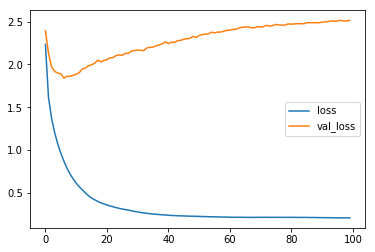

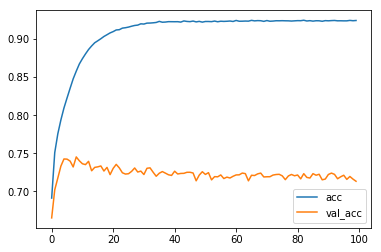

In [45]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [46]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [48]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first character of target sequence with the start character.
    # NOTE: tokenizer lower-cases all words
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # if we get this we break
    eos = word2idx_outputs['<eos>']

    # Create the translation
    output_sentence = []
    for _ in range(max_len_target):
        output_tokens, h, c = decoder_model.predict(
          [target_seq] + states_value
        )
        # output_tokens, h = decoder_model.predict(
        #     [target_seq] + states_value
        # ) # gru

        # Get next word
        idx = np.argmax(output_tokens[0, 0, :])

        # End sentence of EOS
        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)

        # Update the decoder input
        # which is just the word just generated
        target_seq[0, 0] = idx

        # Update states
        states_value = [h, c]
        # states_value = [h] # gru

    return ' '.join(output_sentence)

In [ ]:
while True:
  # Do some test translations
    i = np.random.choice(len(input_texts))
    input_seq = encoder_inputs[i:i+1]
    translation = decode_sequence(input_seq)
    print('-')
    print('Input:', input_texts[i])
    print('Translation:', translation)

    ans = input("Continue? [Y/n]")
    if ans and ans.lower().startswith('n'):
        break


-
Input: I overslept.
Translation: eu dormi demais.
Continue? [Y/n]Thiago is almost done?
-
Input: You're small.
Translation: tu ã©s pequeno.
Continue? [Y/n]i
-
Input: It was cloudy.
Translation: estava nublado.
